# Filtering thymus 111 data

Zoë Steier

* Datasets: Berkeley (ZRS06, ZRS07) and BioLegend (ZRS08)
* Filter cells in thymus 111 data separately for Berkeley and BioLegend cohorts
* Filter genes (variable gene selection considering batch, plus additional genes of interest)

## Imports and settings

In [2]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap

%load_ext autoreload
%autoreload 2
%matplotlib inline

scvi.set_seed(0)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
import matplotlib.colors as mcolors
DPI = 300

## Load data

### Load BioLegend data and filter

In [3]:
# Load data path for BioLegend (8 lanes)

save_path_BioLegend = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/cellranger_aggr/ZRS08_thymus111_aggr/outs/filtered_feature_bc_matrix"

In [4]:
# Load data with scanpy

dataset_BioLegend = sc.read_10x_mtx(save_path_BioLegend, gex_only=False)
dataset_BioLegend.obsm["protein_expression"] = dataset_BioLegend[
    :, dataset_BioLegend.var["feature_types"] == "Antibody Capture"].X.A
dataset_BioLegend.uns["protein_names"] = np.array(
    dataset_BioLegend.var_names[dataset_BioLegend.var["feature_types"] == "Antibody Capture"])
dataset_BioLegend = dataset_BioLegend[
    :, dataset_BioLegend.var["feature_types"] != "Antibody Capture"].copy()
dataset_BioLegend.X = dataset_BioLegend.X.A
dataset_BioLegend.var_names_make_unique()

In [5]:
# Add batch labels
# Add the +11 to distinguish from the Berkeley batch indices

dataset_BioLegend.obs["batch_indices"] = [int(b.split("-")[1]) - 1 + 11 for b in dataset_BioLegend.obs.index]

In [6]:
dataset_BioLegend

AnnData object with n_obs × n_vars = 42406 × 28692
    obs: 'batch_indices'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [7]:
# Find proteins to keep
protein_names = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT206_ADT111_matched.csv")
protein_to_rna_table = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT111_barcodes_RNA_20190717.csv")

# Subset on proteins included in this panel
subset_111 = protein_names["name_206"][~protein_names["name_111"].isnull()].values
keep = []
for i, p in enumerate(dataset_BioLegend.uns["protein_names"]):
    if p in subset_111:
        keep.append(i)
dataset_BioLegend.obsm["protein_expression"] = dataset_BioLegend.obsm["protein_expression"][:, keep]
dataset_BioLegend.uns["protein_names"] = dataset_BioLegend.uns["protein_names"][keep]

# Some genes encode multiple protein so it's ok to overwrite key in this case as it will be included downstream
protein_111_names = protein_names["name_111"][
    ~protein_names["name_111"].isnull()
].values
g_to_p = {}
for p1, p2 in zip(protein_111_names, subset_111):
    ind = np.where(protein_to_rna_table["name"] == p1)[0]
    g_to_p[str(protein_to_rna_table.loc[ind, "RNA"].values[0])] = p2

__Order of filtering:__

1. filter cells by mitochondrial reads
2. filter cells by min genes
3. filter cells by min and max proteins
4. flter genes by min cells expressing them
5. find highly variable genes

In [8]:
# Calculate mitochondrial reads
mito_genes = dataset_BioLegend.var_names.str.startswith("mt-")
dataset_BioLegend.obs["percent_mito"] = np.sum(dataset_BioLegend[:, mito_genes].X, axis=1) / np.sum(dataset_BioLegend.X, axis=1)
dataset_BioLegend.obs['n_counts'] = dataset_BioLegend.X.sum(axis=1)

... storing 'feature_types' as categorical


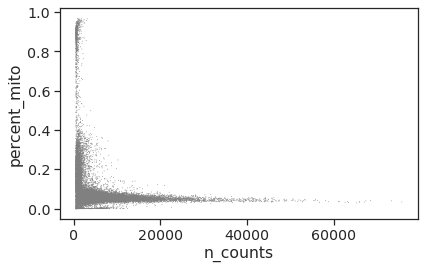

In [9]:
# Plot mitochondrial reads
sc.pl.scatter(dataset_BioLegend, x='n_counts', y='percent_mito')

In [10]:
# Filter cells by mitochondrial reads
dataset_BioLegend = dataset_BioLegend[dataset_BioLegend.obs["percent_mito"] < 0.15, :]
dataset_BioLegend

View of AnnData object with n_obs × n_vars = 38585 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [11]:
# Filter cells by min_genes
sc.pp.filter_cells(dataset_BioLegend, min_genes=200)
dataset_BioLegend

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 38376 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [12]:
# calculate protein library size
dataset_BioLegend.obs["n_protein_counts"] = dataset_BioLegend.obsm["protein_expression"].sum(axis=1)

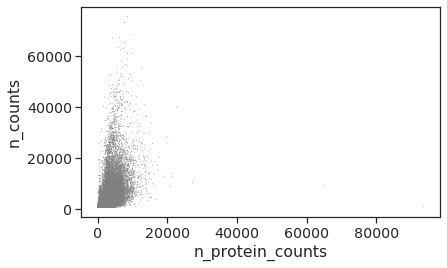

In [13]:
# plot protein library size
sc.pl.scatter(dataset_BioLegend, x='n_protein_counts', y='n_counts')

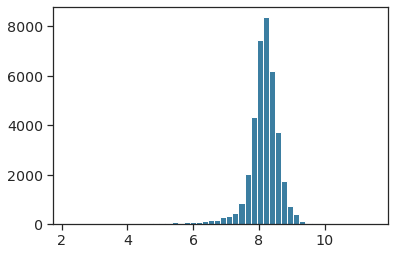

In [14]:
# Plot protein library size
_ = plt.hist(np.log1p(dataset_BioLegend.obs["n_protein_counts"]), bins = 50)

In [15]:
# Filter by protein library size (manually selected based on histogram)
keep_protein_cells = np.logical_and(
    dataset_BioLegend.obs["n_protein_counts"] >= 1000, # 6.9 on ln scale
    dataset_BioLegend.obs["n_protein_counts"] <= 10000, #9.2 on ln scale
)
dataset_BioLegend = dataset_BioLegend[keep_protein_cells]
dataset_BioLegend

View of AnnData object with n_obs × n_vars = 36791 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [16]:
# Filter genes by expression in at least 4 cells
sc.pp.filter_genes(dataset_BioLegend, min_cells=4)
dataset_BioLegend

Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 36791 × 16611
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [17]:
# Calculate number of proteins detected per cell
dataset_BioLegend.obs["n_proteins"] = (dataset_BioLegend.obsm["protein_expression"] > 0).sum(axis=1)

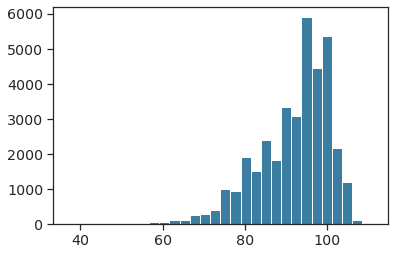

In [18]:
# Plot number of proteins
_ = plt.hist((dataset_BioLegend.obs["n_proteins"]), bins = 30)

In [19]:
# filtering by number of proteins (these were manually selected based on histogram)
keep_protein_cells = dataset_BioLegend.obs["n_proteins"] >= 70
dataset_BioLegend = dataset_BioLegend[keep_protein_cells]

In [20]:
dataset_BioLegend

View of AnnData object with n_obs × n_vars = 35984 × 16611
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts', 'n_proteins'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [21]:
dataset_BioLegend.uns["protein_names"]

array(['ADT_CD102_A0104', 'ADT_CD103_A0201', 'ADT_CD106_A0226',
       'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012',
       'ADT_CD11a_A0595', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227',
       'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195',
       'ADT_CD135_A0098', 'ADT_CD137_A0194', 'ADT_CD14_A0424',
       'ADT_CD140a_A0573', 'ADT_CD15(SSEA-1)_A0076',
       'ADT_CD150(SLAM)_A0203', 'ADT_CD16-32_A0109',
       'ADT_CD169(Siglec-1)_A0440', 'ADT_CD172a(SIRPa)_A0422',
       'ADT_CD183(CXCR3)_A0228', 'ADT_CD184(CXCR4)_A0444',
       'ADT_CD19_A0093', 'ADT_CD192(CCR2)_A0426', 'ADT_CD195(CCR5)_A0376',
       'ADT_CD196(CCR6)_A0225', 'ADT_CD197(CCR7)_A0377', 'ADT_CD20_A0192',
       'ADT_CD200(OX2)_A0079', 'ADT_CD201(EPCR)_A0439',
       'ADT_CD204(Msr1)_A0448', 'ADT_CD206(MMR)_A0173',
       'ADT_CD21-CD35(CR2-CR1)_A0107', 'ADT_CD223(LAG-3)_A0378',
       'ADT_CD23_A0108', 'ADT_CD24_A0212', 'ADT_CD25_A0097',
       'ADT_CD274(B7-H1_PD-L1)_A0190', 'ADT_CD278(ICOS)_A0171',
 

### Load Berkeley data and filter

In [7]:
# Load data path for Berkeley data

save_path_Berkeley = "/data/yosef2/users/zsteier/TotalSeq/20190718_NovaSeq_ZRS07/ZRS07_ZRS06_aggr_nonorm/outs/filtered_feature_bc_matrix"

In [8]:
# Load data with scanpy

dataset_Berkeley = sc.read_10x_mtx(save_path_Berkeley, gex_only=False)
dataset_Berkeley.obsm["protein_expression"] = dataset_Berkeley[
    :, dataset_Berkeley.var["feature_types"] == "Antibody Capture"].X.A
dataset_Berkeley.uns["protein_names"] = np.array(
    dataset_Berkeley.var_names[dataset_Berkeley.var["feature_types"] == "Antibody Capture"])
dataset_Berkeley = dataset_Berkeley[
    :, dataset_Berkeley.var["feature_types"] != "Antibody Capture"].copy()
dataset_Berkeley.X = dataset_Berkeley.X.A
dataset_Berkeley.var_names_make_unique()

In [9]:
# Add batch labels (substract 1 to start indexing at 0)

dataset_Berkeley.obs["batch_indices"] = [int(b.split("-")[1]) - 1 for b in dataset_Berkeley.obs.index]

In [10]:
dataset_Berkeley

AnnData object with n_obs × n_vars = 42983 × 28692
    obs: 'batch_indices'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [26]:
# Find proteins to keep
protein_names = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT206_ADT111_matched.csv")
protein_to_rna_table = pd.read_csv("/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT111_barcodes_RNA_20190717.csv")

# Subset on proteins included in this panel
subset_111 = protein_names["name_111"][~protein_names["name_111"].isnull()].values # Berkeley dataset has 111 names
keep = []
for i, p in enumerate(dataset_Berkeley.uns["protein_names"]):
    if p in subset_111:
        keep.append(i)
dataset_Berkeley.obsm["protein_expression"] = dataset_Berkeley.obsm["protein_expression"][:, keep]
dataset_Berkeley.uns["protein_names"] = dataset_Berkeley.uns["protein_names"][keep]

# Some genes encode multiple protein so it's ok to overwrite key in this case as it will be included downstream
protein_111_names = protein_names["name_111"][
    ~protein_names["name_111"].isnull()
].values
g_to_p = {}
for p1, p2 in zip(protein_111_names, subset_111):
    ind = np.where(protein_to_rna_table["name"] == p1)[0]
    g_to_p[str(protein_to_rna_table.loc[ind, "RNA"].values[0])] = p2

In [27]:
dataset_Berkeley.uns["protein_names"]

array(['CD24_TotalA', 'CD25_TotalA', 'CD62L_TotalA', 'I-A_I-E_TotalA',
       'CD54_TotalA', 'CD83_TotalA', 'CD55_(DAF)_TotalA',
       'TCR_Vg1.1_Cr4_TotalA', 'rat_CD90_mouse_CD90.1_TotalA',
       'CD68_TotalA', 'CD90.2_TotalA', 'CX3CR1_TotalA',
       'TER-119_Erythroid_Cells_TotalA', 'CD366_(Tim-3)_TotalA',
       'CD8b_(Ly-3)_TotalA', 'CD204_(Scavenger_R1)_TotalA', 'CD4_TotalA',
       'CD5_TotalA', 'CD8a_TotalA', 'CD16_32_TotalA', 'CD23_TotalA',
       'CD29_TotalA', 'CD38_TotalA', 'CD45_TotalA', 'CD45R_B220_TotalA',
       'CD49d_TotalA', 'CD69_TotalA', 'CD86_TotalA', 'CD106_TotalA',
       'CD117_(c-kit)_TotalA', 'NK-1.1_TotalA', 'TCR_b_chain_TotalA',
       'CD45.1_TotalA', 'CD19_TotalA', 'CD150_(SLAM)_TotalA',
       'CD11c_TotalA', 'TCR_g_d_TotalA', 'F4_80_TotalA', 'CD14_TotalA',
       'CD21_CD35_(CR2_CR1)_TotalA', 'CD357_(GITR)_TotalA',
       'CD183_(CXCR3)_TotalA', 'CD73_TotalA', 'Ly-6C_TotalA',
       'Siglec_H_TotalA', 'FceRIa_TotalA', 'CD127_(IL-7Ra)_TotalA',
       '

__Order of filtering:__

1. filter cells by mitochondrial reads
2. filter cells by min genes
3. filter cells by min and max proteins
4. flter genes by min cells expressing them
5. find highly variable genes

In [28]:
# Calculate mitochondrial reads
mito_genes = dataset_Berkeley.var_names.str.startswith("mt-")
dataset_Berkeley.obs["percent_mito"] = np.sum(dataset_Berkeley[:, mito_genes].X, axis=1) / np.sum(dataset_Berkeley.X, axis=1)
dataset_Berkeley.obs['n_counts'] = dataset_Berkeley.X.sum(axis=1)

... storing 'feature_types' as categorical


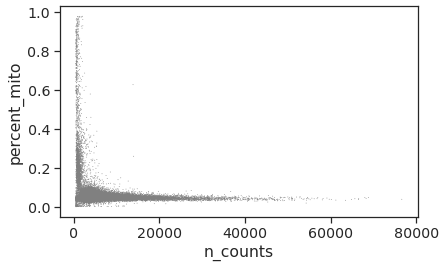

In [29]:
# Plot mitochondrial reads
sc.pl.scatter(dataset_Berkeley, x='n_counts', y='percent_mito')

In [30]:
# Filter cells by mitochondrial reads
dataset_Berkeley = dataset_Berkeley[dataset_Berkeley.obs["percent_mito"] < 0.15, :]
dataset_Berkeley

View of AnnData object with n_obs × n_vars = 41206 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [31]:
# Filter cells by min_genes
sc.pp.filter_cells(dataset_Berkeley, min_genes=200)
dataset_Berkeley

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 41192 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [32]:
# calculate protein library size
dataset_Berkeley.obs["n_protein_counts"] = dataset_Berkeley.obsm["protein_expression"].sum(axis=1)

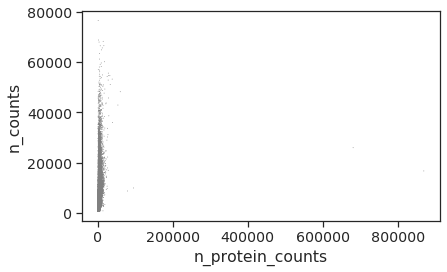

In [33]:
# plot protein library size
sc.pl.scatter(dataset_Berkeley, x='n_protein_counts', y='n_counts')

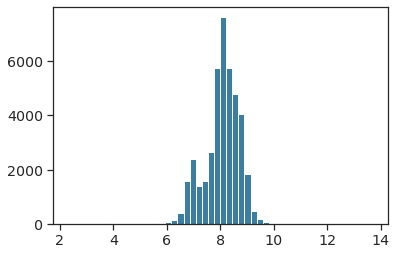

In [34]:
# Plot protein library size
_ = plt.hist(np.log1p(dataset_Berkeley.obs["n_protein_counts"]), bins = 50)

In [35]:
# Filter by protein library size (manually selected based on histogram)
keep_protein_cells = np.logical_and(
    dataset_Berkeley.obs["n_protein_counts"] >= 1000,
    dataset_Berkeley.obs["n_protein_counts"] <= 10000,
)
dataset_Berkeley = dataset_Berkeley[keep_protein_cells]
dataset_Berkeley

View of AnnData object with n_obs × n_vars = 37378 × 28692
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts'
    var: 'gene_ids', 'feature_types'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [36]:
# Filter genes by expression in at least 4 cells
sc.pp.filter_genes(dataset_Berkeley, min_cells=4)
dataset_Berkeley

Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 37378 × 16548
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [37]:
# Rename proteins in Berkeley dataset to match the BioLegend 206 names
berkeley_renamed = []
for name111 in dataset_Berkeley.uns["protein_names"]:
    newname = protein_names.iloc[np.where(protein_names["name_111"] == name111)]["name_206"].values[0]
    berkeley_renamed.append(newname)
                                               
berkeley_renamed = np.array(berkeley_renamed)
dataset_Berkeley.uns["protein_names"] = berkeley_renamed 

In [38]:
# Rearrange Berkeley protein expression data in the same order as the BioLegend data
berkeley_prot_expression = pd.DataFrame(dataset_Berkeley.obsm["protein_expression"], 
                                        columns = dataset_Berkeley.uns["protein_names"])

berkeley_prot_rearranged = berkeley_prot_expression[dataset_BioLegend.uns["protein_names"]]
berkeley_prot_rearranged

,ADT_CD102_A0104,ADT_CD103_A0201,ADT_CD106_A0226,ADT_CD115(CSF-1R)_A0105,ADT_CD117(c-Kit)_A0012,ADT_CD11a_A0595,ADT_CD11c_A0106,ADT_CD122(IL-2Rb)_A0227,ADT_CD127(IL-7Ra)_A0198,ADT_CD134(OX-40)_A0195,...,ADT_TCRVr3_A0210,ADT_TCRbchain_A0120,ADT_TCRr-d_A0121,ADT_TER-119-ErythroidCells_A0122,ADT_Tim-4_A0567,ADT_XCR1_A0568,ADT_anti-P2RY12_A0415,ADT_integrinb7_A0214,HTO_B6_LN_r4_206_A0301,HTO_B6_spl_r4_206_A0302
0,136.0,45.0,4.0,1.0,5.0,527.0,14.0,1.0,29.0,126.0,...,6.0,164.0,6.0,0.0,6.0,5.0,5.0,48.0,108.0,0.0
1,253.0,31.0,3.0,2.0,3.0,946.0,7.0,2.0,15.0,116.0,...,3.0,74.0,7.0,0.0,6.0,4.0,6.0,9.0,141.0,0.0
2,141.0,32.0,2.0,12.0,3.0,505.0,12.0,5.0,18.0,89.0,...,6.0,110.0,3.0,1.0,3.0,8.0,4.0,115.0,128.0,0.0
3,365.0,22.0,7.0,7.0,10.0,412.0,11.0,3.0,7.0,42.0,...,11.0,8.0,7.0,3.0,8.0,8.0,6.0,8.0,65.0,0.0
4,127.0,13.0,8.0,3.0,2.0,851.0,5.0,6.0,8.0,64.0,...,11.0,18.0,7.0,0.0,4.0,4.0,4.0,7.0,79.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37373,80.0,12.0,4.0,2.0,3.0,178.0,1.0,0.0,1.0,15.0,...,3.0,7.0,4.0,0.0,5.0,2.0,2.0,4.0,0.0,0.0
37374,101.0,15.0,4.0,5.0,2.0,118.0,4.0,3.0,2.0,13.0,...,3.0,3.0,3.0,0.0,3.0,2.0,2.0,4.0,0.0,0.0
37375,37.0,16.0,1.0,1.0,2.0,226.0,2.0,1.0,0.0,8.0,...,10.0,19.0,4.0,1.0,1.0,2.0,3.0,5.0,0.0,0.0
37376,125.0,10.0,5.0,1.0,1.0,196.0,2.0,1.0,1.0,10.0,...,3.0,20.0,10.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0


In [39]:
# Add reordered protein expression so that Berkeley and BioLegend data match
dataset_Berkeley.obsm["protein_expression"] = np.asarray(berkeley_prot_rearranged)

In [43]:
# Reorder protein_names to match protein_expression
dataset_Berkeley.uns["protein_names"] = berkeley_prot_rearranged.columns.values

In [45]:
# Calculate number of proteins detected per cell
dataset_Berkeley.obs["n_proteins"] = (dataset_Berkeley.obsm["protein_expression"] > 0).sum(axis=1)

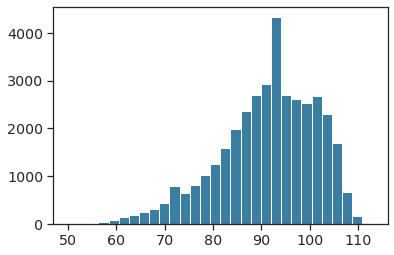

In [46]:
# Plot number of proteins
_ = plt.hist((dataset_Berkeley.obs["n_proteins"]), bins = 30)

In [47]:
# filtering by number of proteins (these were manually selected based on histogram)
keep_protein_cells = dataset_Berkeley.obs["n_proteins"] >= 70
dataset_Berkeley = dataset_Berkeley[keep_protein_cells]

In [48]:
dataset_Berkeley

View of AnnData object with n_obs × n_vars = 36058 × 16548
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts', 'n_proteins'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'protein_names'
    obsm: 'protein_expression'

## Find highly variable genes and genes of interest

### Find genes of interest
Genes are related to TCR signaling pathways and fate commitment

In [49]:
# Load two lists of genes of interest (genes are related to TCR signaling pathways and fate commitment)
Laura_genes = pd.read_csv("Laura_genes_of_interest.csv")
Laura_genes = np.asarray([gene.lower().capitalize() for gene in Laura_genes.Gene])
ZRS_genes = np.array(pd.read_csv("ZRS_genes_of_interest.csv").Gene)

In [50]:
# Find overlap with gene lists
genes_of_interest = np.unique(np.concatenate((Laura_genes, ZRS_genes))) # keep unique genes
len(genes_of_interest)

256

### Find highly variable genes

In [51]:
# Concatenate the two datasets
# Batch indices will retain the values 0-18
# Batch will be 0, 1 for Berkeley, BioLegend

adata_total = anndata.AnnData.concatenate(dataset_Berkeley, dataset_BioLegend)
# For this purpose, set batch_indices equal to batch (because batch_indices are used to create HVG list in scVI)
adata_total.obs["batch_indices"] = adata_total.obs["batch"]
adata_total

AnnData object with n_obs × n_vars = 72042 × 15948
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts', 'n_proteins', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells-0', 'n_cells-1'
    obsm: 'protein_expression'

In [52]:
adata_total.obs["batch_indices"]

AAACCCAAGACTACCT-1-0    0
AAACCCAAGGACATCG-1-0    0
AAACCCACATTCTCCG-1-0    0
AAACGAACACGCTGCA-1-0    0
AAACGCTGTCAACACT-1-0    0
                       ..
TTTGATCTCACCTACC-8-1    1
TTTGGAGCAGACCTGC-8-1    1
TTTGGTTTCGACCATA-8-1    1
TTTGTTGAGTTTGAGA-8-1    1
TTTGTTGGTGTTCGAT-8-1    1
Name: batch_indices, Length: 72042, dtype: category
Categories (2, object): [0, 1]

In [53]:
# Find highly variable genes using scVI implementation of Seurat v3 method
# Find HVGs per batch, where Berkeley is one batch and BioLegend is a second

# Create scVI dataset from anndata object
dataset = AnnDatasetFromAnnData(ad = adata_total)

# Find highly variable genes by Seurat v3 method using Berkeley/BioLegend as batch info
dataset.subsample_genes(new_n_genes = 5000, mode = "seurat_v3", batch_correction = True)
dataset

[2020-05-29 12:46:39,445] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-05-29 12:46:39,449] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-05-29 12:47:35,713] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-29 12:47:37,612] INFO - scvi.dataset.dataset | Downsampled from 72042 to 72042 cells
[2020-05-29 12:47:37,630] INFO - scvi.dataset.dataset | extracting highly variable genes using seurat_v3 flavor


/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_065/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[2020-05-29 12:48:57,457] INFO - scvi.dataset.dataset | Downsampling from 15948 to 5000 genes
[2020-05-29 12:49:03,696] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-29 12:49:05,199] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-05-29 12:49:10,228] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-05-29 12:49:10,812] INFO - scvi.dataset.dataset | Downsampled from 72042 to 72042 cells


GeneExpressionDataset object with n_cells x nb_genes = 72042 x 5000
    gene_attribute_names: 'feature_types', 'gene_names', 'gene_ids', 'n_cells-0', 'n_cells-1'
    cell_attribute_names: 'n_protein_counts', 'n_counts', 'local_vars', 'n_genes', 'local_means', 'batch', 'batch_indices', 'percent_mito', 'n_proteins', 'labels'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [54]:
# Get names of 5000 highly variable genes
highly_variable = dataset.gene_names

### Select genes to keep

In [55]:
# Reset batch indices
dataset_BioLegend.obs["batch_indices"] = dataset_BioLegend.obs["batch_indices"] - 11 

Trying to set attribute `.obs` of view, copying.


In [56]:
# Add highly variable gene labels to the datasets
# Find which genes are highly variable in each of the sets
dataset_Berkeley.var["highly_variable"] = [gene in highly_variable for gene in dataset_Berkeley.var.index]
dataset_BioLegend.var["highly_variable"] = [gene in highly_variable for gene in dataset_BioLegend.var.index]

Trying to set attribute `.var` of view, copying.


In [57]:
# Berkeley data
# Keep genes that encode proteins
encode = []
for g in dataset_Berkeley.var.index:
    if g in g_to_p.keys():
        encode.append(g_to_p[g])
    else:
        encode.append(None)
encode = np.array(encode)
dataset_Berkeley.var["encode"] = encode

# Also keep genes that are of interest
ofinterest = [gene in genes_of_interest for gene in dataset_Berkeley.var.index]
dataset_Berkeley.var["ofinterest"] = ofinterest

# highly variable and encode protein
dataset_Berkeley.var["hvg_encode"] = np.logical_or(
    (dataset_Berkeley.var["highly_variable"]).values, (dataset_Berkeley.var["encode"].values != None)
)

# highly variable/encode protein or is a gene of interest
dataset_Berkeley.var["hvg_plus"] = np.logical_or(
    (dataset_Berkeley.var["hvg_encode"]).values, (dataset_Berkeley.var["ofinterest"].values)
)

#BioLegend data
# Keep genes that encode proteins
encode = []
for g in dataset_BioLegend.var.index:
    if g in g_to_p.keys():
        encode.append(g_to_p[g])
    else:
        encode.append(None)
encode = np.array(encode)
dataset_BioLegend.var["encode"] = encode

# Also keep genes that are of interest
ofinterest = [gene in genes_of_interest for gene in dataset_BioLegend.var.index]
dataset_BioLegend.var["ofinterest"] = ofinterest

# highly variable and encode protein
dataset_BioLegend.var["hvg_encode"] = np.logical_or(
    (dataset_BioLegend.var["highly_variable"]).values, (dataset_BioLegend.var["encode"].values != None)
)

# highly variable/encode protein or is a gene of interest
dataset_BioLegend.var["hvg_plus"] = np.logical_or(
    (dataset_BioLegend.var["hvg_encode"]).values, (dataset_BioLegend.var["ofinterest"].values)
)

In [58]:
# Keep genes of interest
# In total, the additional genes of interest added 108 genes and genes that encode proteins added 17
np.sum(dataset_Berkeley.var["hvg_plus"]) - np.sum(dataset_BioLegend.var["hvg_encode"])

108

In [59]:
np.sum(dataset_Berkeley.var["hvg_encode"])

5017

In [60]:
print("hvg_plus contains {} genes".format(np.sum(dataset_Berkeley.var["hvg_plus"])))
print("hvg_plus contains {} genes".format(np.sum(dataset_BioLegend.var["hvg_plus"])))

hvg_plus contains 5125 genes
hvg_plus contains 5125 genes


## Save anndata objects

In [61]:
os.getcwd()

'/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/analysis/totalVI_thymus/thymus111_allbatches_stable'

In [62]:
dataset_Berkeley.write("Berkeley_111.h5ad", compression="gzip")
dataset_BioLegend.write("BioLegend_111.h5ad", compression="gzip")

... storing 'encode' as categorical
... storing 'encode' as categorical
